# Logistic Regression Stock Market Forecasting
This Jupyter notebook demonstrates the use of **Logistic Regression** for **stock market forecasting**. It processes historical stock data, engineers features such as technical indicators, volume and price changes, and then trains a logistic regression model to predict whether the stock price will go up or down. The model's performance is evaluated using classification metrics, and the results are visualized for both training and testing data.

## Import Libraries

In [480]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from tabulate import tabulate


## Data
We use `META` data from `2020-01-01` to the current date.

In [481]:
# Define the stock symbol and the date range for our data
stock_symbol = 'META'
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"{stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

META
Start Date: 2020-01-01
End Date: 2024-12-09


### Download Data
We download the data, and select the `Close` and `Volume` columns

In [482]:
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Close', 'Volume']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,Volume
Date,,
2020-01-02,209.779999,12077100
2020-01-03,208.669998,11188400
2020-01-06,212.600006,17058900
2020-01-07,213.059998,14912400
2020-01-08,215.220001,13475000


### Visualize Chart

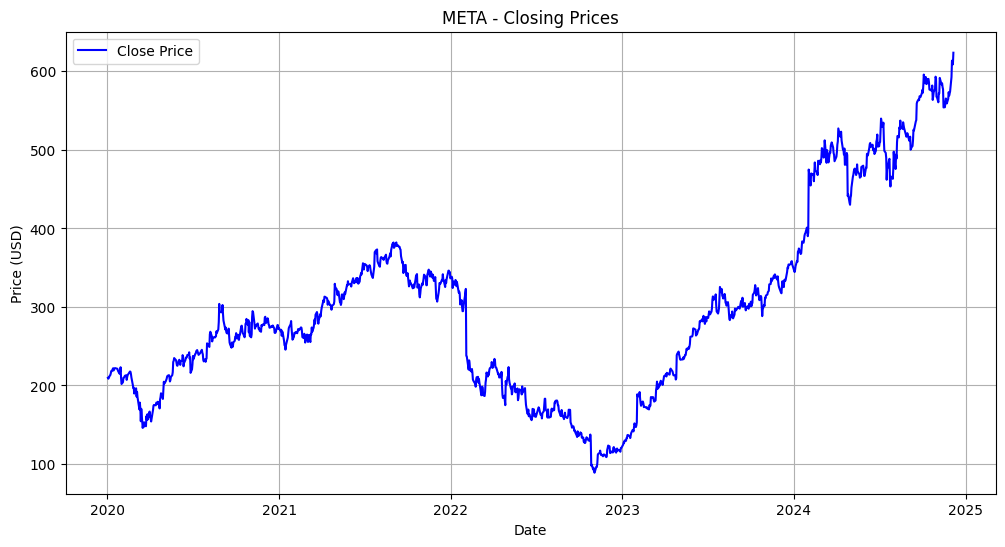

In [483]:
# Plot the original closing prices
plt.figure(figsize=(12, 6))

# Plot the 'Close' price column
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

# Add title and labels
plt.title(f'{stock_symbol} - Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Add a legend
plt.legend()

# Add gridlines
plt.grid(True)

plt.savefig(f'{stock_symbol}_closing_prices.png')

# Show the plot
plt.show()


## Target Variable
In this step, we create a **Target** column to indicate whether the stock price will go up or down in the next period. A value of `1` represents that the price will go up, and `0` indicates a price drop. We achieve this by comparing the next day's closing price with the current day's closing price. Afterward, we drop any rows containing `NaN` values, which were introduced by the shift operation. The resulting dataframe is displayed to show the new **Target** column.

In [484]:
# Add a column indicating whether the price will go up (1) or down (0)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaN values (caused by shifting)
df.dropna(inplace=True)

# Display the head of the dataframe
df.head()

Price,Close,Volume,Target
Date,,,
2020-01-02,209.779999,12077100,0
2020-01-03,208.669998,11188400,1
2020-01-06,212.600006,17058900,1
2020-01-07,213.059998,14912400,1
2020-01-08,215.220001,13475000,1


## Feature Engineering

### Adding the `Return` Feature

This cell calculates the percentage change in the closing price (Return) to capture daily price movement. It also removes any rows with NaN values caused by the calculation. Finally, it displays the first few rows of the updated dataframe.

In [485]:
# Add the 'Return' feature (percentage change)
df['Return'] = df['Close'].pct_change()

# Drop rows with NaN values after feature engineering
df.dropna(inplace=True)

# Display the head of the dataframe
df.head()

Price,Close,Volume,Target,Return
Date,,,,
2020-01-03,208.669998,11188400,1,-0.005291
2020-01-06,212.600006,17058900,1,0.018834
2020-01-07,213.059998,14912400,1,0.002164
2020-01-08,215.220001,13475000,1,0.010138
2020-01-09,218.300003,12642800,0,0.014311


### Adding the `Weekday` Feature

This cell adds a new feature called Weekday, which represents the day of the week as a numeric value (0 = Monday, 6 = Sunday). This feature helps capture any patterns or trends related to specific days of the week.

In [486]:
# Add 'Weekday' feature (numeric representation: 0=Monday, ..., 6=Sunday)
df['Weekday'] = df.index.dayofweek

# Display the head of the dataframe
df.head()

Price,Close,Volume,Target,Return,Weekday
Date,,,,,
2020-01-03,208.669998,11188400,1,-0.005291,4
2020-01-06,212.600006,17058900,1,0.018834,0
2020-01-07,213.059998,14912400,1,0.002164,1
2020-01-08,215.220001,13475000,1,0.010138,2
2020-01-09,218.300003,12642800,0,0.014311,3


### Adding the `RSI` Feature

This cell calculates the **Relative Strength Index (RSI)**, a momentum indicator that measures the speed and change of price movements. The RSI helps identify overbought or oversold conditions in the market. The RSI is calculated using a 14-day window and added as a new feature to the dataframe. Rows with NaN values generated by the RSI calculation are dropped.

In [487]:
# Function to calculate Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff()  # Calculate the difference in price
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Positive gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Negative losses
    rs = gain / loss  # Relative strength
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    return rsi

# Add the 'RSI' feature
df['RSI'] = compute_rsi(df['Close'])

# Drop rows with NaN values after adding RSI
df.dropna(inplace=True)

# Display the head of the dataframe
df.head()


Price,Close,Volume,Target,Return,Weekday,RSI
Date,,,,,,
2020-01-23,219.759995,11195000,0,-0.007049,3,75.170181
2020-01-24,217.940002,11905800,0,-0.008282,4,69.433954
2020-01-27,214.869995,13810700,1,-0.014086,0,54.936901
2020-01-28,217.789993,13413800,1,0.013590,1,59.292712
2020-01-29,223.229996,33181300,0,0.024978,2,63.940110


### `Volume` Change Feature

This feature calculates the **percentage change in volume** from one day to the next. A positive value indicates an increase in volume, while a negative value suggests a decrease. Tracking these changes can help identify significant shifts in market activity, which may precede price movements.

In [488]:
# Calculate the percentage change in volume (similar to how we calculate price change)
df['Volume_Change'] = df['Volume'].pct_change()

# Drop rows with NaN values (caused by percentage change)
df.dropna(inplace=True)

# Display the head of the dataframe
df.head()

Price,Close,Volume,Target,Return,Weekday,RSI,Volume_Change
Date,,,,,,,
2020-01-24,217.940002,11905800,0,-0.008282,4,69.433954,0.063493
2020-01-27,214.869995,13810700,1,-0.014086,0,54.936901,0.159998
2020-01-28,217.789993,13413800,1,0.013590,1,59.292712,-0.028739
2020-01-29,223.229996,33181300,0,0.024978,2,63.940110,1.473669
2020-01-30,209.529999,48775500,0,-0.061372,3,38.856417,0.469970


### Data Split

In [489]:
# Define features and target variable
features = ['Return', 'Weekday', 'RSI', 'Volume_Change']

# Select features and target from the dataframe
X = df[features]
y = df['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


## Train Logistic Regression Model

### Train

In this step, we create a **pipeline** to streamline the process of scaling the features and training the logistic regression model. The pipeline consists of two stages: 

1. **Scaling**: The `StandardScaler` is used to standardize the features, ensuring they have a mean of 0 and a standard deviation of 1.
2. **Model Training**: A **Logistic Regression** model is used to learn from the scaled features.

The pipeline is then fitted on the training data (`X_train`, `y_train`), allowing the model to learn and make predictions based on the provided features.

In [490]:
# Create a pipeline for scaling and model training
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Fit the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

### Evaluate

Here, we make predictions using the trained model on both the training (`X_train`) and testing (`X_test`) data. The predictions are stored in `y_train_pred` and `y_test_pred`, respectively.

In [491]:
# Make predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

This step calculates the **confusion matrix** for the training data, comparing the actual vs. predicted values. The matrix is then visualized as a **heatmap**, where the colors represent the counts of true positives, true negatives, false positives, and false negatives. This provides insight into the model's performance in correctly classifying the target variable.

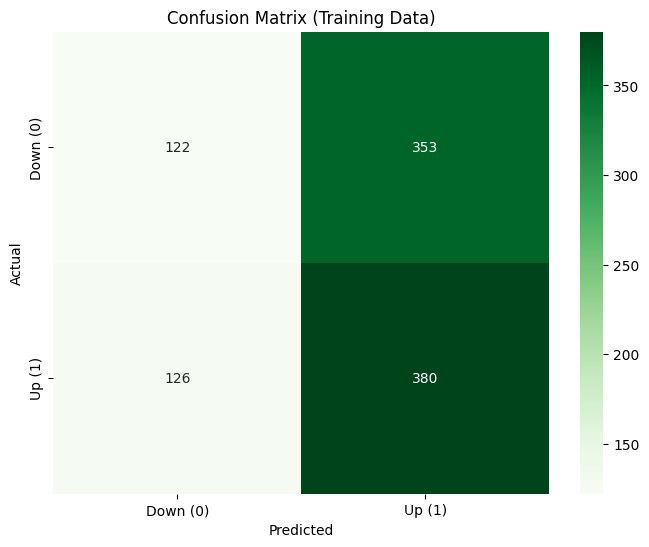

In [492]:
# Confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Greens", xticklabels=['Down (0)', 'Up (1)'], yticklabels=['Down (0)', 'Up (1)'])
plt.title("Confusion Matrix (Training Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In this step, we display the classification report for the training data.

In [493]:
# Generate the classification report
train_report = classification_report(y_train, y_train_pred, output_dict=True)

# Format the report for display using tabulate
report_table = []
for label, metrics in train_report.items():
    if isinstance(metrics, dict):  # For the metrics of each class
        row = [label] + [f"{metrics['precision']:.3f}", f"{metrics['recall']:.3f}", f"{metrics['f1-score']:.3f}", f"{metrics['support']}"]
    else:  # For accuracy, macro avg, and weighted avg
        row = [label] + [f"{metrics:.3f}" if isinstance(metrics, float) else metrics]
    report_table.append(row)

# Print the table in a clean format
print("Training Performance:")
print(tabulate(report_table, headers=["Metric", "Precision", "Recall", "F1-Score", "Support"], tablefmt="pretty"))


Training Performance:
+--------------+-----------+--------+----------+---------+
|    Metric    | Precision | Recall | F1-Score | Support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.492   | 0.257  |  0.337   |  475.0  |
|      1       |   0.518   | 0.751  |  0.613   |  506.0  |
|   accuracy   |   0.512   |        |          |         |
|  macro avg   |   0.505   | 0.504  |  0.475   |  981.0  |
| weighted avg |   0.506   | 0.512  |  0.480   |  981.0  |
+--------------+-----------+--------+----------+---------+


Classification report for the training data.

In [494]:
# Generate the classification report
test_report = classification_report(y_test, y_test_pred, output_dict=True)

# Format the report for display using tabulate
report_table = []
for label, metrics in test_report.items():
    if isinstance(metrics, dict):  # For the metrics of each class
        row = [label] + [f"{metrics['precision']:.3f}", f"{metrics['recall']:.3f}", f"{metrics['f1-score']:.3f}", f"{metrics['support']}"]
    else:  # For accuracy, macro avg, and weighted avg
        row = [label] + [f"{metrics:.3f}" if isinstance(metrics, float) else metrics]
    report_table.append(row)

# Print the table in a clean format
print("Testing Performance:")
print(tabulate(report_table, headers=["Metric", "Precision", "Recall", "F1-Score", "Support"], tablefmt="pretty"))


Testing Performance:
+--------------+-----------+--------+----------+---------+
|    Metric    | Precision | Recall | F1-Score | Support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.582   | 0.411  |  0.482   |  112.0  |
|      1       |   0.605   | 0.754  |  0.671   |  134.0  |
|   accuracy   |   0.598   |        |          |         |
|  macro avg   |   0.594   | 0.582  |  0.576   |  246.0  |
| weighted avg |   0.595   | 0.598  |  0.585   |  246.0  |
+--------------+-----------+--------+----------+---------+


### Test Data Confusion Matrix Visualization

In this step, we compute the **confusion matrix** for the test data, which compares the actual vs. predicted values. The confusion matrix is visualized using a **heatmap**, making it easier to interpret. The heatmap shows the number of true positives, true negatives, false positives, and false negatives, providing insights into how well the model is predicting both "up" and "down" days.

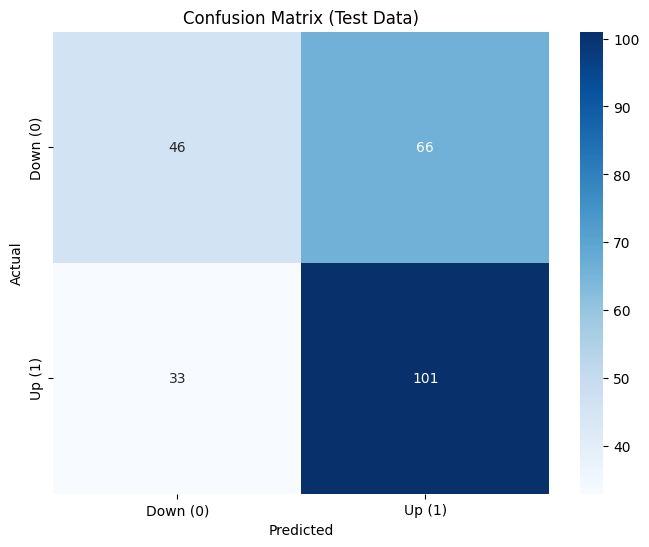

In [495]:
# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Down (0)', 'Up (1)'], yticklabels=['Down (0)', 'Up (1)'])
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("test_data_confusion.png")
plt.show()


In [496]:
# Accuracy score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.51
Testing Accuracy: 0.60


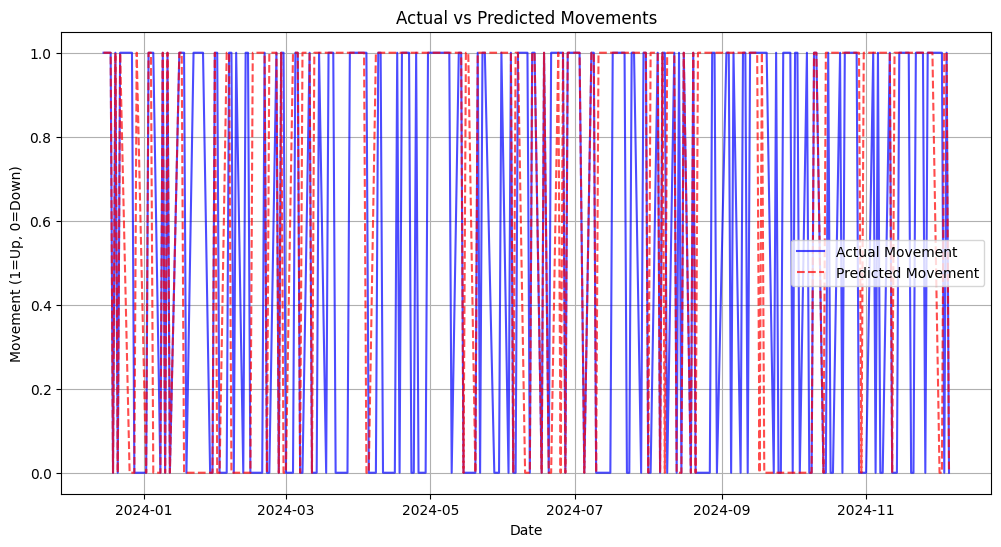

In [497]:
# Add predictions to the test set for plotting
X_test['Predicted'] = y_test_pred
X_test['Actual'] = y_test.values

plt.figure(figsize=(12, 6))

# Plot actual vs predicted
plt.plot(X_test.index, X_test['Actual'], label='Actual Movement', color='blue', alpha=0.7)
plt.plot(X_test.index, X_test['Predicted'], label='Predicted Movement', color='red', linestyle='--', alpha=0.7)

plt.title('Actual vs Predicted Movements')
plt.xlabel('Date')
plt.ylabel('Movement (1=Up, 0=Down)')
plt.legend()
plt.grid(True)

plt.savefig(f'{stock_symbol}_movement_forecast.png')
plt.show()
